In [54]:
import numpy as np
import torch
import os
import glob
import time
import copy

from pathlib import Path
from tqdm import tqdm


In [55]:
config = {
    "data_config" : {
        "batch_size" : 32,
        "train_ratio" : 0.8,
    },
    "train_config" : {
        "epochs" : 100,
        "lr" : 1e-5
    },
    "model_config" : {
        'in_channels': 1024,
        'num_classes': 6
    }
}
if torch.cuda.is_available():
    from torch.cuda import FloatTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = "cuda"
else:
    from torch import FloatTensor
    device = "cpu"

In [104]:
from torch.utils.data import Dataset

def preprocess_data(data_path):
    img_list = sorted([file for file in glob.glob(os.path.join(data_path, "*")) if not os.path.basename(file).startswith('.')])
    label_list = [int(img_list[i].split('_')[-1][0])-1 for i in range(len(img_list))]
    try:
        label_list = [int(img_list[i].split('_')[-1][0])-1 for i in range(len(img_list))] # 1 ~ n -> 0 ~ n-1
    except:
        label_list = [-1 for i in range(len(img_list))]
    imgs = np.array([np.load(img_list[idx]).transpose(2,0,1) for idx in range(len(img_list))])
    labels = np.array(list(map(float, label_list)))

    return imgs, labels

class BasicDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.FloatTensor(self.imgs[idx])
        label = self.labels[idx]

        if self.transform:
          img = self.transform(img)

        return img, label

In [57]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### resnet layer 사용해보기

In [86]:
def reset_weights(m):
   '''
    Try resetting model weights to avoid
    weight leakage.
   '''
   for layer in m.children():
      if hasattr(layer, 'reset_parameters'):
         # print(f'Reset trainable parameters of layer = {layer}')
         layer.reset_parameters()
   # print('reset parameters')

In [59]:
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 1024 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        self.layer4 = self._make_layer(block, 256, layers, stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer4(x)
        #x.shape =[1024, 7, 7]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [61]:
from torchsummary import summary
resnet50 = ResNet(block=resnet.Bottleneck, layers=3, num_classes=6, zero_init_residual=True).to(device) 
summary(resnet50, input_size=(1024, 14, 14), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 14, 14]         262,144
       BatchNorm2d-2          [-1, 256, 14, 14]             512
              ReLU-3          [-1, 256, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         589,824
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7           [-1, 1024, 7, 7]         262,144
       BatchNorm2d-8           [-1, 1024, 7, 7]           2,048
            Conv2d-9           [-1, 1024, 7, 7]       1,048,576
      BatchNorm2d-10           [-1, 1024, 7, 7]           2,048
             ReLU-11           [-1, 1024, 7, 7]               0
       Bottleneck-12           [-1, 1024, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         262,144
      BatchNorm2d-14            [-1, 25

In [109]:
root_path = Path("./Embryo")
data_path = root_path / "dataset" / "challenge" / "train"

imgs, targets = preprocess_data(data_path=data_path)

In [119]:
from tqdm import tqdm
import time
import copy
from torch.utils.data import DataLoader

dataset = BasicDataset(imgs, targets)
batch_size = 16
train_data, val_data = torch.utils.data.random_split(dataset, [400, 100], generator=torch.Generator(device=device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

dataloaders= {'train' : train_loader, "valid" : val_loader}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=(root_path / 'checkpoint.pt'))
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.to(torch.int64))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            # if phase == 'train':
            #     scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu())
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                early_stopping(epoch_loss, model)
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.3f'%(best_idx, best_acc))
                
        if early_stopping.early_stop:
            print("Early stopping")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.3f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), (root_path / 'president_model.pt'))
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

model = ResNet(block=resnet.Bottleneck, layers=3, num_classes=6, zero_init_residual=True).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)


model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, scheduler=None, num_epochs=200)

Epoch 0/199
----------
train Loss: 1.76 Acc: 0.19000
Validation loss decreased (inf --> 1.740699).  Saving model ...
valid Loss: 1.74 Acc: 0.20000
==> best model saved - 0 / 0.200
Epoch 1/199
----------
train Loss: 1.68 Acc: 0.27250
Validation loss decreased (1.740699 --> 1.736439).  Saving model ...
valid Loss: 1.74 Acc: 0.17000
Epoch 2/199
----------
train Loss: 1.67 Acc: 0.25000
Validation loss decreased (1.736439 --> 1.726363).  Saving model ...
valid Loss: 1.73 Acc: 0.17000
Epoch 3/199
----------
train Loss: 1.66 Acc: 0.33500
Validation loss decreased (1.726363 --> 1.723863).  Saving model ...
valid Loss: 1.72 Acc: 0.26000
==> best model saved - 3 / 0.260
Epoch 4/199
----------
train Loss: 1.64 Acc: 0.36250
Validation loss decreased (1.723863 --> 1.707011).  Saving model ...
valid Loss: 1.71 Acc: 0.19000
Epoch 5/199
----------
train Loss: 1.63 Acc: 0.33250
Validation loss decreased (1.707011 --> 1.699326).  Saving model ...
valid Loss: 1.70 Acc: 0.21000
Epoch 6/199
----------
trai

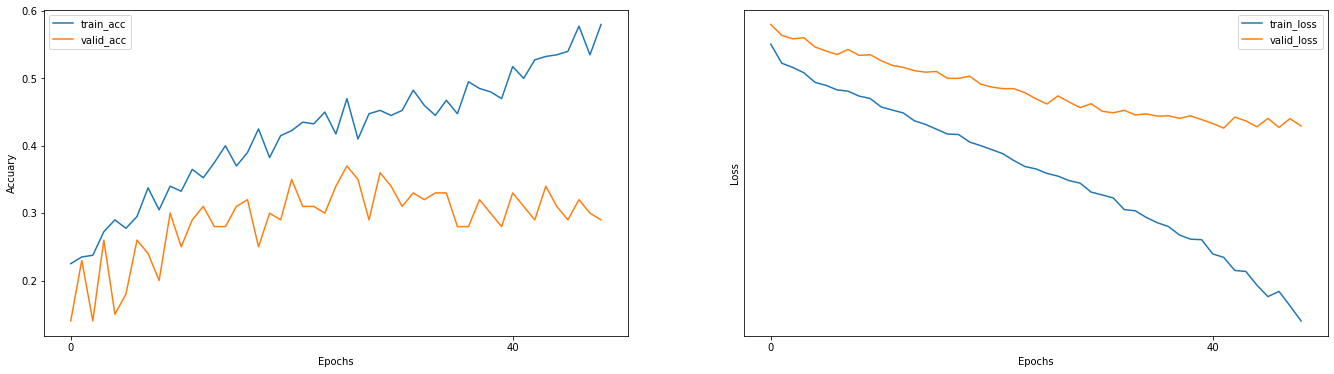

In [100]:
import matplotlib.pyplot as plt

num_epochs = 200

plt.figure(figsize=(23,6))
plt.subplot(1,2,1)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Epochs")
plt.ylabel("Accuary")
plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.legend()

plt.subplot(1,2,2)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 3, 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss, label="train_loss")
plt.plot(valid_loss, label="valid_loss")
plt.legend()
plt.show()

In [87]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

batch_size = config['data_config']['batch_size']
in_channels = config['model_config']['in_channels']
num_classes = config['model_config']['num_classes']
num_epochs = config['train_config']['epochs']
lr  = config['train_config']['lr']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_train_loss, fold_train_acc, fold_valid_loss, fold_valid_acc, results = [], [], [], [], {}

for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, targets)):
    print(f'------ Fold {fold} Start ------')
    # print("Train_idx : ", len(train_idx), "Val_idx : ", len(val_idx))
    since = time.time()
    
    # model 선언
    # model = Model(in_channels=in_channels, num_classes=num_classes).to(device)
    model = ResNet(block=resnet.Bottleneck, layers=3, num_classes=6, zero_init_residual=True).to(device) 
    model.apply(reset_weights)
    
    # optimizer & criterion & scheduler 선언
    criterion = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.3)
    scheduler = None
    
    early_stopping = EarlyStopping(patience = 5, verbose = True)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    # kfold를 통해 train과 val를 구분지음
    train_img, train_label = imgs[train_idx], targets[train_idx]
    val_img, val_label = imgs[val_idx], targets[val_idx]
    
    # np array를 tensor화하고 Dataset으로 만듦
    train_data = BasicDataset(train_img, train_label, transform=None)
    val_data = BasicDataset(val_img, val_label, transform=None)
    
    # Dataloader에 넣음
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
    
    dataloaders = {'train':train_loader, 'valid':val_loader,}
    
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-'*10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss, running_corrects, num_cnt = 0.0, 0, 0
                
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.to(torch.int64))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            # if phase == 'train':
            #     scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu())
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                early_stopping(epoch_loss, model)
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                results[fold] = best_acc * 100
                best_model_wts = copy.deepcopy(model.state_dict())
                #best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
                
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))    
    
    # load best model weights 검증단계이므로 굳이 저장하지말자 나중에 좋은 모델 발견하면 그때 저장하지뭐

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'president_model_fold{fold+1}.pt')
    print('model saved')
        
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

    fold_train_acc.append(train_acc)
    fold_train_loss.append(train_loss)
    fold_valid_acc.append(valid_acc)
    fold_valid_loss.append(valid_loss)

avg_train_acc = np.mean(np.array(fold_train_acc), axis=0)
avg_train_loss = np.mean(np.array(fold_train_loss), axis=0)
avg_valid_acc = np.mean(np.array(fold_valid_acc), axis=0)
avg_valid_loss = np.mean(np.array(fold_valid_loss), axis=0)

------ Fold 0 Start ------
Epoch 1/100
----------
train Loss: 1.83 Acc: 0.16000
Validation loss decreased (inf --> 1.808782).  Saving model ...
valid Loss: 1.81 Acc: 0.11000
==> best model saved - 1 / 0.1
Epoch 2/100
----------
train Loss: 1.76 Acc: 0.21500
Validation loss decreased (1.808782 --> 1.769723).  Saving model ...
valid Loss: 1.77 Acc: 0.15000
==> best model saved - 2 / 0.1
Epoch 3/100
----------
train Loss: 1.70 Acc: 0.31500
Validation loss decreased (1.769723 --> 1.743037).  Saving model ...
valid Loss: 1.74 Acc: 0.21000
==> best model saved - 3 / 0.2
Epoch 4/100
----------
train Loss: 1.66 Acc: 0.38000
Validation loss decreased (1.743037 --> 1.723204).  Saving model ...
valid Loss: 1.72 Acc: 0.25000
==> best model saved - 4 / 0.2
Epoch 5/100
----------
train Loss: 1.62 Acc: 0.42750
Validation loss decreased (1.723204 --> 1.711602).  Saving model ...
valid Loss: 1.71 Acc: 0.26000
==> best model saved - 5 / 0.3
Epoch 6/100
----------
train Loss: 1.59 Acc: 0.51750
Validation

C:\Users\53789\AppData\Local\Temp\ipykernel_14736\983539357.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_train_acc = np.mean(np.array(fold_train_acc), axis=0)
C:\Users\53789\AppData\Local\Temp\ipykernel_14736\983539357.py:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_train_loss = np.mean(np.array(fold_train_loss), axis=0)
C:\Users\53789\AppData\Local\Temp\ipykernel_14736\983539357.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

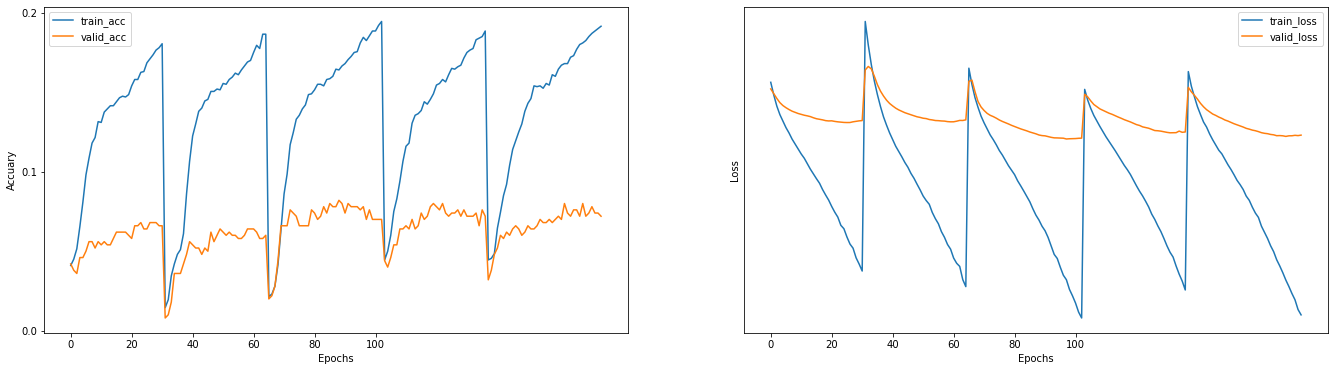

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(23,6))
plt.subplot(1,2,1)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Epochs")
plt.ylabel("Accuary")
plt.plot(avg_train_acc, label="train_acc")
plt.plot(avg_valid_acc, label="valid_acc")
plt.legend()

plt.subplot(1,2,2)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 3, 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(avg_train_loss, label="train_loss")
plt.plot(avg_valid_loss, label="valid_loss")
plt.legend()
plt.show()

In [43]:
from sklearn.model_selection import KFold

def train_model(num_epochs=100):
    results = {}
    
    kfold = KFold(n_splits=5, shuffle=False)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        since = time.time()
        
        train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        trainloader = torch.utils.data.DataLoader(
                            dataset, 
                            batch_size=batch_size, sampler=train_subsampler)
        valloader = torch.utils.data.DataLoader(
                            dataset,
                      batch_size=batch_size, sampler=val_subsampler)
        
        dataloaders = { "train" : trainloader, "valid" : valloader}
        
        model = ResNet(block=resnet.Bottleneck, layers=3, num_classes=6, zero_init_residual=True).to(device)
        model.apply(reset_weights)

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, nesterov=True, momentum=0.9)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.3)
        criterion = torch.nn.CrossEntropyLoss()
        
        early_stopping = EarlyStopping(patience = 5, verbose = True)
    
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss, running_corrects, num_cnt = 0.0, 0, 0
                
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels.to(torch.int64))

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    num_cnt += len(labels)
                # if phase == 'train':
                #     scheduler.step()
                
                epoch_loss = float(running_loss / num_cnt)
                epoch_acc  = float((running_corrects.double() / num_cnt).cpu())
                
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    early_stopping(epoch_loss, model)
                    valid_loss.append(epoch_loss)
                    valid_acc.append(epoch_acc)
                print('{} Loss: {:.2f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))
            
                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_idx = epoch
                    best_acc = epoch_acc
                    results[fold] = best_acc * 100
                    best_model_wts = copy.deepcopy(model.state_dict())
                    #best_model_wts = copy.deepcopy(model.module.state_dict())
                    print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
            
            if early_stopping.early_stop:
                print("Early stopping")
                break

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), f'president_model_fold{fold+1}.pt')
        print('model saved')
        
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model()

2048
Reset trainable parameters of layer = Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
Reset trainable parameters of layer = BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1)

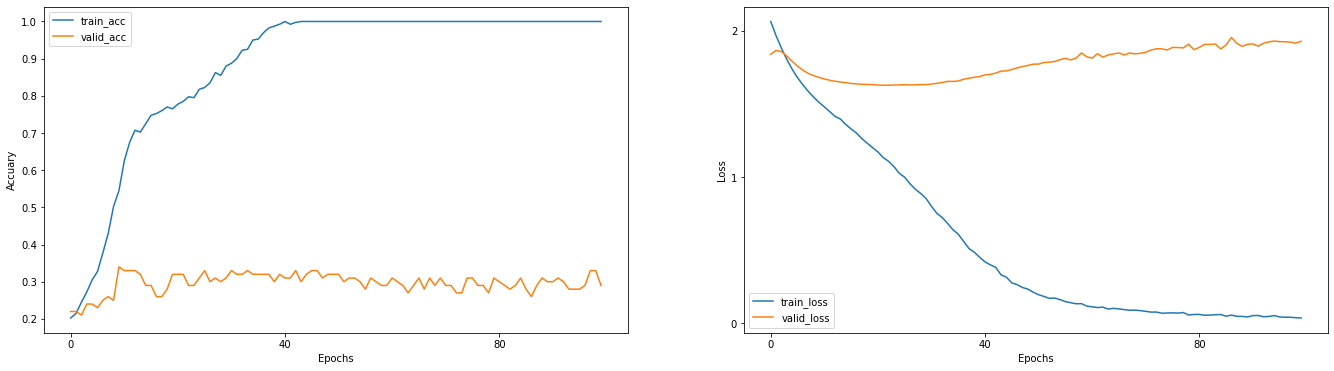

In [16]:
import matplotlib.pyplot as plt

num_epochs = 200

plt.figure(figsize=(23,6))
plt.subplot(1,2,1)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Epochs")
plt.ylabel("Accuary")
plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.legend()

plt.subplot(1,2,2)
plt.xticks(np.arange(0,num_epochs+1, num_epochs//5))
plt.yticks(np.arange(0, 3, 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss, label="train_loss")
plt.plot(valid_loss, label="valid_loss")
plt.legend()
plt.show()

## Test Set Prediction

In [124]:
test_data_dir = root_path / "dataset" / 'challenge' / 'test'

test_imgs, test_labels = preprocess_data(test_data_dir)
test_data = BasicDataset(test_imgs, test_labels)

testloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator(device=device))

model = ResNet(Bottleneck, layers=3, num_classes=6)
model.load_state_dict(torch.load('Embryo/checkpoint.pt'))
model.to(device)

model.eval()

for idx, (imgs, labels) in tqdm(enumerate(testloader), total=len(testloader), desc=f'prediction', unit=' batch'):
    with torch.no_grad():
        imgs = imgs.to(device)
        outputs = model(imgs)
        
        preds = outputs.max(1, keepdim=True)[1].flatten().tolist() # outputs.max -> values, indices

        with open(root_path / 'embryo-submission.csv', 'a') as f:
          for pred in preds:
            f.write(str(pred+1)+'\n') # 0 ~ n-1 -> 1 ~ n

prediction: 100%|██████████| 7/7 [00:00<00:00, 44.03 batch/s]
